**What is transfer learning?**

Transfer learning is a machine learning technique where a model created for a specific task is used as the starting point for a model on a different task. In this method, a model trained on one task, called the source task, is fine-tuned and adapted to work on another, related task, known as the target task. The aim is to capitalize on the knowledge gained from the source task to improve learning and performance on the target task, especially when there is limited labeled data available for the target task.

**where the differences are that make the loss plot different between the first two notebooks. ?**

The differences between the two code snippets:

**First Difference:**

**Model Initialization:**

***First code (model = models.resnet18()):***

Initializes ResNet-18 without pre-trained weights.

Model starts with random weights.

Ideal for training from scratch on a specific task and dataset.

***Second code (orig_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)):***

Initializes ResNet-18 with pre-trained weights from ImageNet.

Utilizes meaningful features learned from a diverse dataset.

Beneficial for tasks similar to ImageNet classification.

Eases fine-tuning, especially with limited task-specific data, potentially leading to better performance.

**Second Difference:**

**Learning Rate Scheduler:**

***First Code :***

Fixed Learning Rate: The model is trained with a fixed learning rate (lr=0.001) using the SGD optimizer throughout the training process.

No learning rate scheduler is used. The learning rate remains constant.    

***code 2 (Learning Rate Scheduler):***

Introduces a linear learning rate scheduler (lr_scheduler.LinearLR) alongside the SGD optimizer.

Dynamic Learning Rate Adjustment: The learning rate linearly decreases from start_factor (1.0) to end_factor (0.25) over a total of 10 iterations (total_iters=10).

scheduler.step() is called inside the training loop to adjust the learning rate during each iteration.

This dynamic adjustment of the learning rate is particularly valuable for training deep learning models. It enables faster convergence during the initial phases and more precise fine-tuning as the training progresses, potentially leading to improved overall performance on the task at hand.                                                   

In [1]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Clone the GitHub Repository
!git clone https://github.com/skokalj/RowanDLclassNEA.git

Cloning into 'RowanDLclassNEA'...
remote: Enumerating objects: 1833, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1833 (delta 1), reused 5 (delta 0), pack-reused 1826
Receiving objects: 100% (1833/1833), 57.56 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (3602/3602), done.


In [3]:
%cd RowanDLclassNEA/

/content/RowanDLclassNEA


In [4]:
!ls

NEUdata  NEUdata_split	README.md


### **Problem 1 - ablation study**

In [5]:
import torch

In [6]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',))

In [7]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

In [8]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset,
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set,
                    batch_size=16,
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set,
                    batch_size=16,
                    shuffle=True)

print(len(trainloader))
# out: 75
print(len(valloader))
# out: 38

75
38


In [9]:
dset_test = DatasetFolder(root='NEUdata_split', loader = load_image, extensions = ('.bmp',), transform = transform)
testloader = torch.utils.data.DataLoader(
                    dset_test,
                    batch_size=16,
                    shuffle=True)

**NEACLASS 1: with Initializing ResNet-18 without pre-trained weights and without learning rate scheduler**

In [16]:
!pip install torchinfo

In [11]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

model = models.resnet18()
summary(model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers = list(model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
alt_model = model
alt_model.fc = nn.Linear(512,6)

In [12]:
from torch import optim
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch,
                  train_loss/len(trainloader),
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.1139726877212524 Val Loss: 4.47858116501256
Epoch: 1 Train Loss: 0.7295239508152008 Val Loss: 0.9115617094855559
Epoch: 2 Train Loss: 0.5901749235391617 Val Loss: 1.2685989862994145
Epoch: 3 Train Loss: 0.5436059182882309 Val Loss: 0.5265721412081468
Epoch: 4 Train Loss: 0.43884845902522407 Val Loss: 1.684968606421822
Epoch: 5 Train Loss: 0.3760618745287259 Val Loss: 0.24129028373250835
Epoch: 6 Train Loss: 0.28084516525268555 Val Loss: 0.20387838087289742
Epoch: 7 Train Loss: 0.34949758226672806 Val Loss: 0.31842194830900744
Epoch: 8 Train Loss: 0.33553027361631393 Val Loss: 0.33606687722433554
Epoch: 9 Train Loss: 0.2390984410047531 Val Loss: 0.2961837878744853
Epoch: 10 Train Loss: 0.20297877992192903 Val Loss: 0.15244014507257625
Epoch: 11 Train Loss: 0.2296880205720663 Val Loss: 0.3874801914942892
Epoch: 12 Train Loss: 0.17446747340261937 Val Loss: 0.16859751907912524
Epoch: 13 Train Loss: 0.14139215139051278 Val Loss: 0.7293210780542148
Epoch: 14 Train Loss

Text(0.5, 1.0, 'Loss Curves')

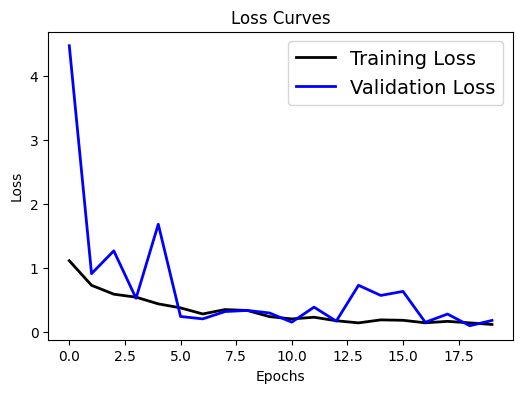

In [13]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [16]:
correct_predictions = 0
total_predictions = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_predictions) * 100
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Test Accuracy: 17.94%


**with Initializing ResNet-18 with pre-trained weights and without learning rate scheduler**

In [17]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
alt_model = orig_model
alt_model.fc = nn.Linear(512,6)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


In [18]:
from torch import optim
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch,
                  train_loss/len(trainloader),
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.5367310681939125 Val Loss: 0.04936725879088044
Epoch: 1 Train Loss: 0.08534165166318416 Val Loss: 0.024618400150517885
Epoch: 2 Train Loss: 0.04368321469053626 Val Loss: 0.01041394479474739
Epoch: 3 Train Loss: 0.02581910684083899 Val Loss: 0.005324434773922947
Epoch: 4 Train Loss: 0.027218396024157602 Val Loss: 0.009737989754955234
Epoch: 5 Train Loss: 0.01835463068758448 Val Loss: 0.005910871239489336
Epoch: 6 Train Loss: 0.010434664643835277 Val Loss: 0.0037429661077974167
Epoch: 7 Train Loss: 0.02068839413424333 Val Loss: 0.0030678624025313184
Epoch: 8 Train Loss: 0.01606311116522799 Val Loss: 0.0022313600776741574
Epoch: 9 Train Loss: 0.008338573531558117 Val Loss: 0.0018316734498703706
Epoch: 10 Train Loss: 0.009589749308458219 Val Loss: 0.0016341560495723236
Epoch: 11 Train Loss: 0.015881141933302086 Val Loss: 0.0016812906038754399
Epoch: 12 Train Loss: 0.0064789195455765974 Val Loss: 0.0013001157430584211
Epoch: 13 Train Loss: 0.0059185285553879415 Val Lo

Text(0.5, 1.0, 'Loss Curves')

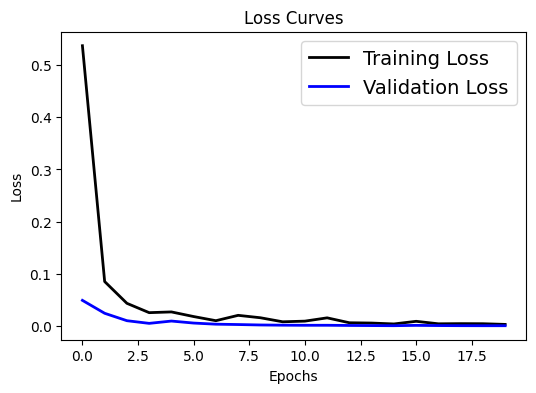

In [19]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [20]:
correct_predictions = 0
total_predictions = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_predictions) * 100
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Test Accuracy: 16.67%


**with Initializing ResNet-18 without pre-trained weights and with learning rate scheduler**

In [21]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

model = models.resnet18()
summary(model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers = list(model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
alt_model = model
alt_model.fc = nn.Linear(512,6)

In [22]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch,
                  train_loss/len(trainloader),
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.3849294845263163 Val Loss: 1.3794382543940293
Epoch: 1 Train Loss: 0.9486626116434733 Val Loss: 0.7919192682755621
Epoch: 2 Train Loss: 0.7293266828854879 Val Loss: 0.7223420103913859
Epoch: 3 Train Loss: 0.6316523961226146 Val Loss: 1.0291086952937276
Epoch: 4 Train Loss: 0.5811514516671499 Val Loss: 0.7060397698691017
Epoch: 5 Train Loss: 0.5122168668111166 Val Loss: 0.44368130086283936
Epoch: 6 Train Loss: 0.44779099106788633 Val Loss: 0.3730203556387048
Epoch: 7 Train Loss: 0.418562974135081 Val Loss: 0.7806095198581093
Epoch: 8 Train Loss: 0.39151633699735006 Val Loss: 0.5585586844306243
Epoch: 9 Train Loss: 0.41537704636653267 Val Loss: 0.2520116983275664
Epoch: 10 Train Loss: 0.3697149556875229 Val Loss: 0.74723853896323
Epoch: 11 Train Loss: 0.3532211392124494 Val Loss: 1.1305451761735112
Epoch: 12 Train Loss: 0.3370579739411672 Val Loss: 0.2946485691752873
Epoch: 13 Train Loss: 0.3148552308479945 Val Loss: 0.29823208737530205
Epoch: 14 Train Loss: 0.2925

Text(0.5, 1.0, 'Loss Curves')

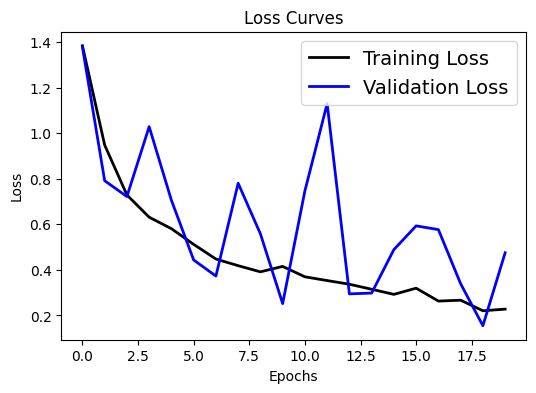

In [23]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [24]:
correct_predictions = 0
total_predictions = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_predictions) * 100
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Test Accuracy: 15.17%


**NEACLASS 2: with Initializing ResNet-18 with pre-trained weights and with learning rate scheduler**

In [25]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
alt_model = orig_model
alt_model.fc = nn.Linear(512,6)

In [26]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch,
                  train_loss/len(trainloader),
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.8666685312986374 Val Loss: 0.27546923607587814
Epoch: 1 Train Loss: 0.3063531645139058 Val Loss: 0.12027980632295734
Epoch: 2 Train Loss: 0.178562148809433 Val Loss: 0.0659420327528527
Epoch: 3 Train Loss: 0.12144749159614245 Val Loss: 0.040900385154313164
Epoch: 4 Train Loss: 0.08634764015674591 Val Loss: 0.029802968554002673
Epoch: 5 Train Loss: 0.07082744897653659 Val Loss: 0.01982693410919685
Epoch: 6 Train Loss: 0.056829116797695554 Val Loss: 0.015999528322074758
Epoch: 7 Train Loss: 0.0640798515578111 Val Loss: 0.012860438455582449
Epoch: 8 Train Loss: 0.04539236407106122 Val Loss: 0.01269734959657255
Epoch: 9 Train Loss: 0.04476495484200617 Val Loss: 0.00971703467228891
Epoch: 10 Train Loss: 0.04251133661717176 Val Loss: 0.009065647039709515
Epoch: 11 Train Loss: 0.03313709298769633 Val Loss: 0.00945805979120594
Epoch: 12 Train Loss: 0.026693800014133254 Val Loss: 0.006171432149130851
Epoch: 13 Train Loss: 0.02577920451760292 Val Loss: 0.005722531868071344

Text(0.5, 1.0, 'Loss Curves')

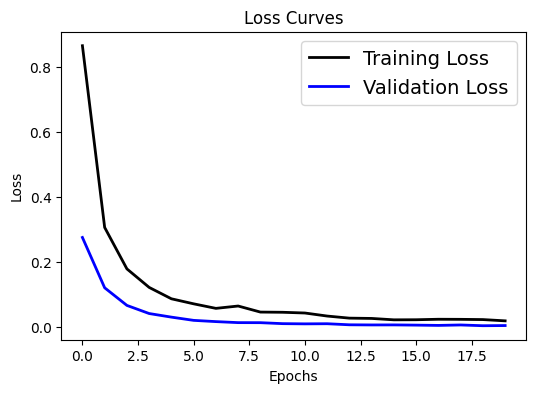

In [27]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [28]:
correct_predictions = 0
total_predictions = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_predictions) * 100
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Test Accuracy: 16.67%


**Write what affected the loss and accuracy and how. Does addition of a learning rate scheduler change anything in this case?**

***Initializing ResNet-18 without pre-trained weights and without a learning rate scheduler:***

Train Loss: 0.1165

Validation Loss: 0.1795

Test Accuracy: 17.94%

***Initializing ResNet-18 with pre-trained weights and without a learning rate scheduler:***

Train Loss: 0.0033

Validation Loss: 0.0008

Test Accuracy: 16.67%

***Initializing ResNet-18 without pre-trained weights and with a learning rate scheduler:***

Train Loss: 0.2276

Validation Loss: 0.4753

Test Accuracy: 15.17%

***Initializing ResNet-18 with pre-trained weights and with a learning rate scheduler:***

Train Loss: 0.0184

Validation Loss: 0.0038

Test Accuracy: 16.67%

**Scenario 1:**

Without pre-trained weights, the model started with random parameters.
The relatively higher train loss indicates that the model struggled to learn meaningful features from the training data. The model showed moderate performance on the test set, achieving an accuracy of 17.94%.

**Scenario 2:**

Pre-trained weights provided a head start, enabling the model to learn from features already extracted on the ImageNet dataset.
The extremely low training and validation losses indicate the model quickly adapted to the task. Despite the low losses, the test accuracy remained at 16.67%, suggesting the model might have overfitted to the training data or struggled to generalize well.

**Scenario 3:**

Without pre-trained weights, the model had to learn from scratch, leading to a higher training loss. The learning rate scheduler helped in training stability, but the model still faced challenges in capturing essential patterns, as evident from the higher validation loss and lower test accuracy.

**Scenario 4:**

Pre-trained weights provided a foundation for learning.
The learning rate scheduler ensured stable convergence, leading to significantly lower training and validation losses compared to Scenario 2.
Despite the lower losses, the test accuracy remained at 16.67%, indicating potential overfitting or difficulty in generalizing to unseen data.

**Summary:**

***Pre-trained Weights:***
Pre-trained weights consistently resulted in lower losses, indicating the usefulness of pre-trained features for the task.

***Learning Rate Scheduler:***
The learning rate scheduler contributed to stable training but did not significantly impact test accuracy in these scenarios.

**Insights:**

***Overfitting Possibility:***
Scenarios 2 and 4 had very low training and validation losses but similar test accuracies as other scenarios. This suggests potential overfitting to the training data.

***Complexity Consideration:***
The task might require a more complex model or additional techniques like regularization or data augmentation to improve generalization.

**Explain the differences with respect to neoclass2.ipynb**

**Model Architecture neaclass2:**

Feature Extraction Layers:

Extracts all layers from orig_model except the last one (commonly the classification layer).
Adds a flattening layer (nn.Flatten()) to convert the extracted features into a 1D tensor.
Forms vec_model as a sequential model with these layers.

Classification Layer Modification:

Adds a linear (fully connected) layer at the end of vec_model to perform classification into 6 classes.

Freezing Layers:

None of the layers in vec_model are frozen, meaning they are all trainable during training.

**Model Architecture neaclass3:**

Feature Extraction Layers:

Extracts all layers from orig_model except the last one.
Adds a flattening layer to convert the features into a 1D tensor.
Forms vec_model as a sequential model with these layers.

Classification Layer Modification:

Adds a linear (fully connected) layer at the end of vec_model to perform classification into 6 classes.

Freezing Layers:

Freezes all the layers in vec_model, making them non-trainable during training.



#NEACLASS 3

**Model 1**

In [ ]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

In [30]:
#Here first deepcopy  orig_model (where we instantiated resnet18 with pretrained weights): this will create an INDEPENDENT graph
#Then just replace model.fc with the linear layer
import copy
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

In [31]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = alt_model.to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter



N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch,
                  train_loss/len(trainloader),
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.8971871767441432 Val Loss: 0.31898153769342524
Epoch: 1 Train Loss: 0.2882723453640938 Val Loss: 0.13662159001748814
Epoch: 2 Train Loss: 0.18637915536761285 Val Loss: 0.07046118638429202
Epoch: 3 Train Loss: 0.12016541796425978 Val Loss: 0.04747582298066271
Epoch: 4 Train Loss: 0.07688838471968969 Val Loss: 0.03041799759835397
Epoch: 5 Train Loss: 0.06830672819167376 Val Loss: 0.02336087626846213
Epoch: 6 Train Loss: 0.057101652516673006 Val Loss: 0.018362275349270357
Epoch: 7 Train Loss: 0.043249101104835666 Val Loss: 0.014776118969740836
Epoch: 8 Train Loss: 0.044639513473957775 Val Loss: 0.012294596208161429
Epoch: 9 Train Loss: 0.0421794084024926 Val Loss: 0.01220998320556981
Epoch: 10 Train Loss: 0.03466596350694696 Val Loss: 0.010225684774157247
Epoch: 11 Train Loss: 0.030830478519201277 Val Loss: 0.009905697848329223
Epoch: 12 Train Loss: 0.02737257756603261 Val Loss: 0.007831845475409768
Epoch: 13 Train Loss: 0.026533419645080963 Val Loss: 0.007366609388

Text(0.5, 1.0, 'Loss Curves')

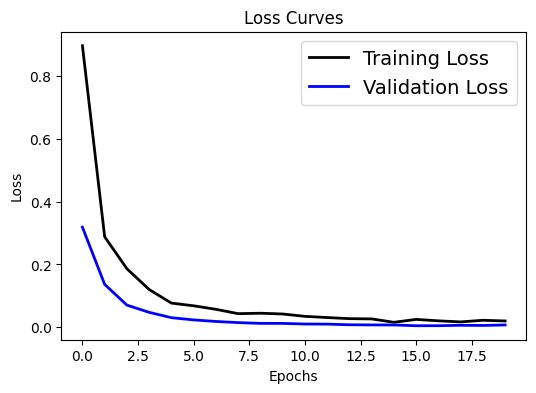

In [32]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [33]:
correct_predictions = 0
total_predictions = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_predictions) * 100
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Test Accuracy: 16.67%


**Model 2**

In [34]:
#Used the shortened model (vec_model) to build upon it later, but first **freeze its parameters** (disable further training)
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())
vec_model = nn.Sequential(*layers)
for param in vec_model.parameters():
    param.requires_grad = False

In [35]:
layers = list(vec_model.children())  #get all the layers except the last one
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        (9,408)
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        (128)
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-6                    [16, 64, 56, 56]  

In [36]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch,
                  train_loss/len(trainloader),
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.3849347138404846 Val Loss: 0.8484030663967133
Epoch: 1 Train Loss: 0.7555097524325053 Val Loss: 0.498082445640313
Epoch: 2 Train Loss: 0.5341863441467285 Val Loss: 0.3630472288319939
Epoch: 3 Train Loss: 0.41434039374192555 Val Loss: 0.2807552296864359
Epoch: 4 Train Loss: 0.3524237221479416 Val Loss: 0.23853900636497297
Epoch: 5 Train Loss: 0.3100362080335617 Val Loss: 0.20485699039540792
Epoch: 6 Train Loss: 0.27771921853224435 Val Loss: 0.17740244908552422
Epoch: 7 Train Loss: 0.2507881400982539 Val Loss: 0.16842896177580483
Epoch: 8 Train Loss: 0.24221665809551876 Val Loss: 0.147531951826654
Epoch: 9 Train Loss: 0.23066150645414987 Val Loss: 0.13817090099971546
Epoch: 10 Train Loss: 0.2189050304889679 Val Loss: 0.1282681552203078
Epoch: 11 Train Loss: 0.20347318331400555 Val Loss: 0.12480508330229081
Epoch: 12 Train Loss: 0.19829531967639924 Val Loss: 0.11602411830895826
Epoch: 13 Train Loss: 0.17135498474041622 Val Loss: 0.10739878692517155
Epoch: 14 Train L

Text(0.5, 1.0, 'Loss Curves')

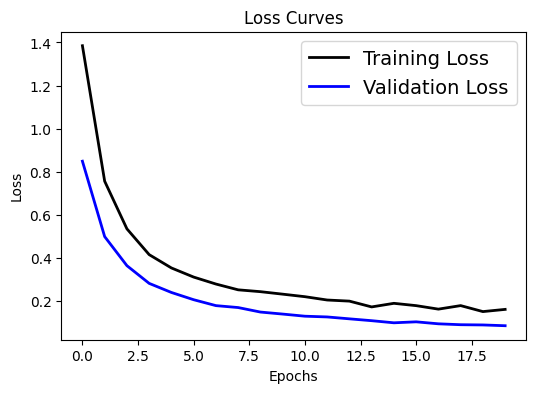

In [37]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [38]:
correct_predictions = 0
total_predictions = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_predictions) * 100
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Test Accuracy: 17.22%


**Accuracies of both models:**

***First model:***  Test Accuracy: 16.67%

***Second model:***  Test Accuracy: 17.22%


### **Problem 2 – Autoencoder**

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18

In [12]:
# Define the Convolutional Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
# Load NEU dataset using a DataLoader
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])
dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)
train_size = int(0.8 * len(dset))
train_dataset, test_dataset = random_split(dset, [train_size, len(dset) - train_size])
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [14]:
# Initialize the autoencoder model, loss function, and optimizer
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [15]:
# Training the autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader)}')

Epoch 1/50, Loss: 0.42564883877833687
Epoch 2/50, Loss: 0.36939310779174167
Epoch 3/50, Loss: 0.3655986992849244
Epoch 4/50, Loss: 0.36517952630917233
Epoch 5/50, Loss: 0.3625906778706445
Epoch 6/50, Loss: 0.3620821598503325
Epoch 7/50, Loss: 0.3610621247026655
Epoch 8/50, Loss: 0.3611196216609743
Epoch 9/50, Loss: 0.36023627668619157
Epoch 10/50, Loss: 0.36013913005590437
Epoch 11/50, Loss: 0.36004363381200366
Epoch 12/50, Loss: 0.35968921664688325
Epoch 13/50, Loss: 0.3601575780245993
Epoch 14/50, Loss: 0.35955937289529377
Epoch 15/50, Loss: 0.35949188354942535
Epoch 16/50, Loss: 0.35938932448625566
Epoch 17/50, Loss: 0.35972580346796246
Epoch 18/50, Loss: 0.3591780083047019
Epoch 19/50, Loss: 0.35944251269102095
Epoch 20/50, Loss: 0.35899823125865726
Epoch 21/50, Loss: 0.35890599398149386
Epoch 22/50, Loss: 0.35931468076176115
Epoch 23/50, Loss: 0.3589466970827844
Epoch 24/50, Loss: 0.3589306142595079
Epoch 25/50, Loss: 0.3587108827299542
Epoch 26/50, Loss: 0.35873604036039775
Epoch

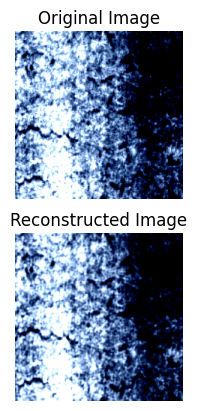

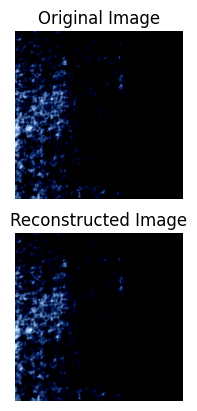

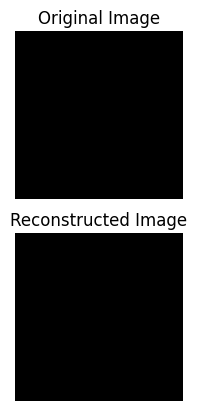

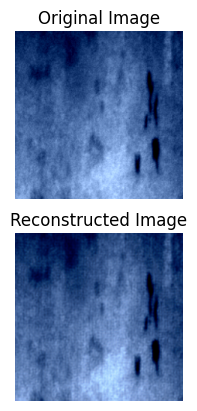

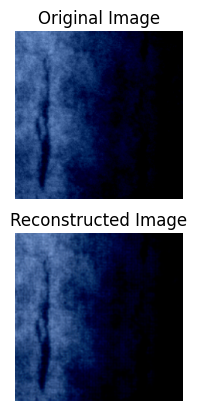

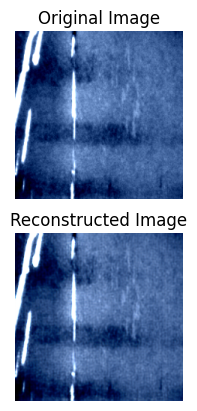

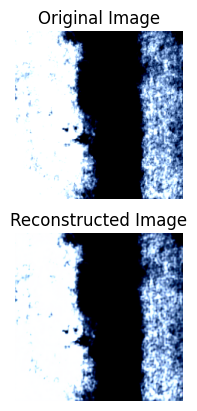

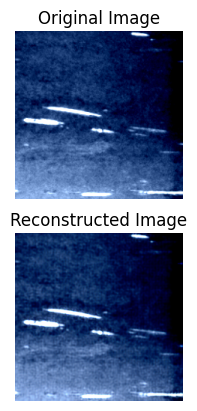

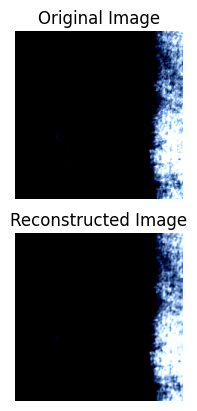

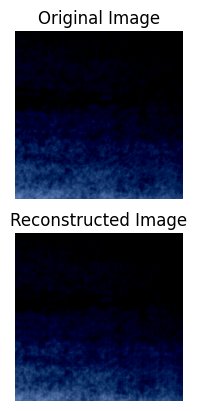

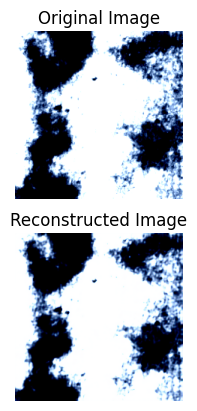

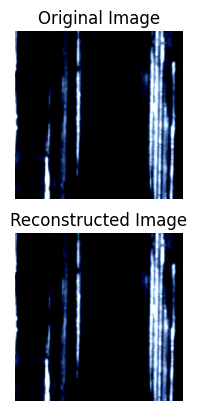

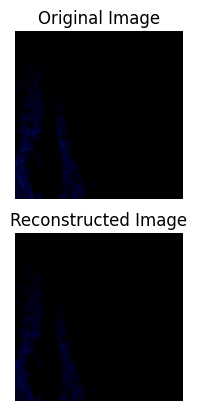

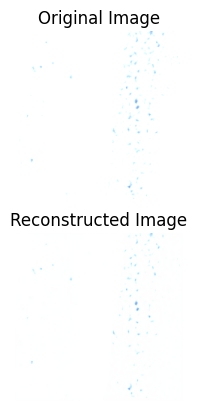

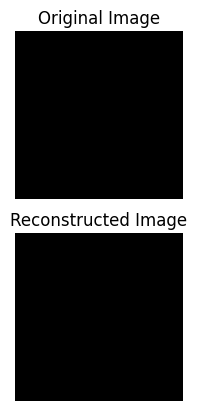

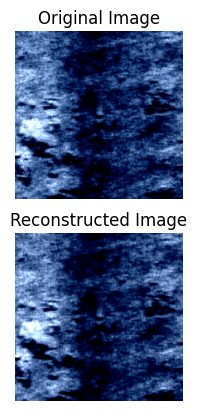

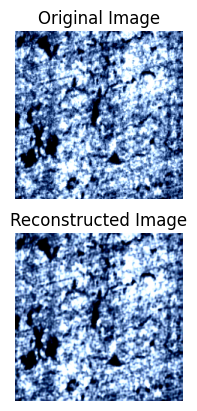

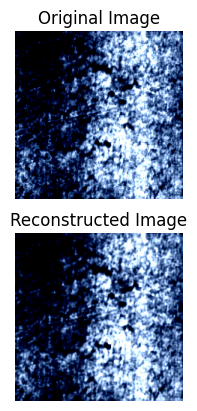

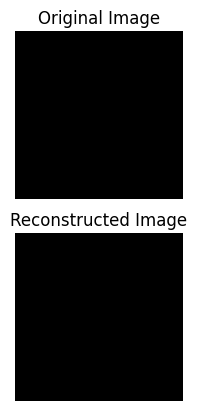

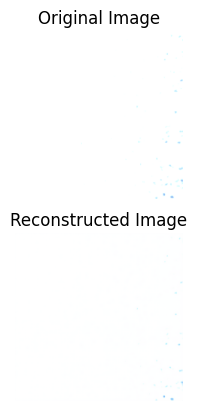

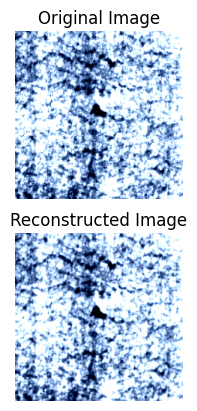

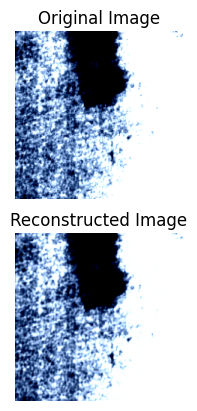

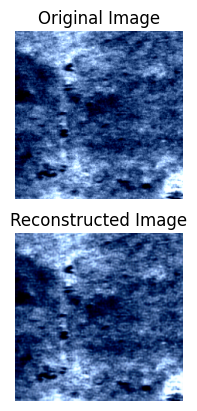

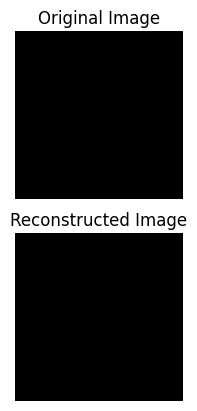

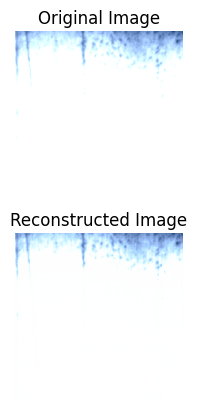

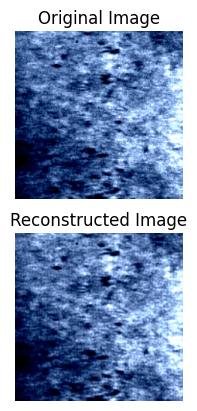

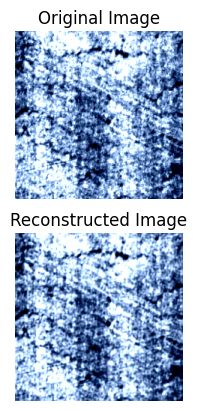

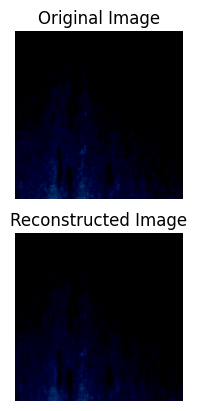

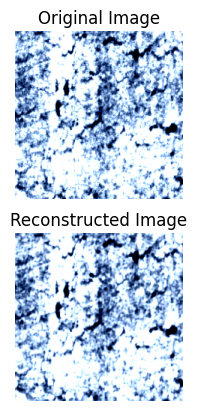

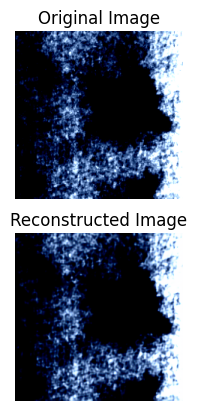

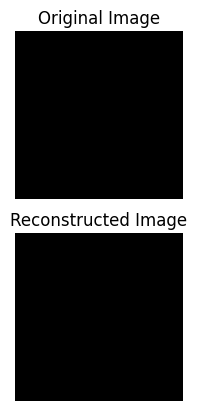

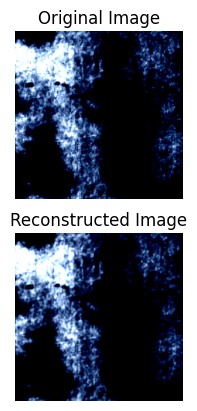

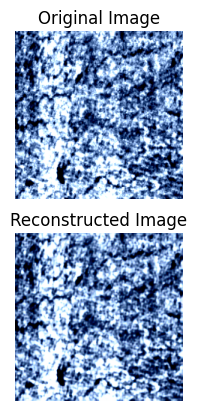

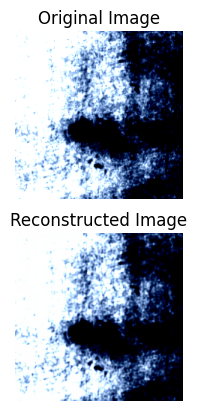

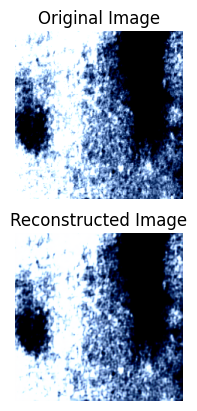

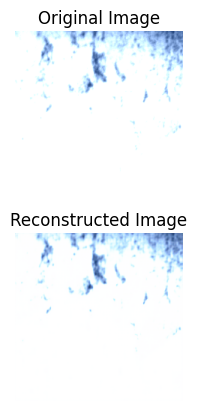

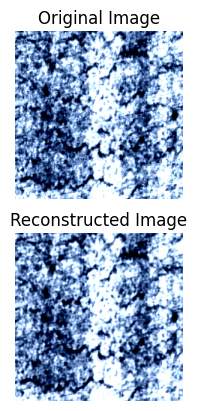

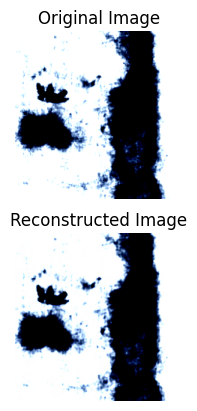

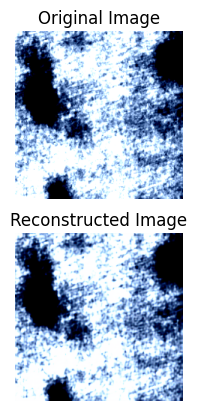

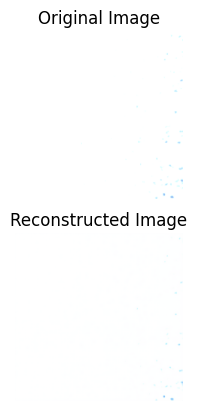

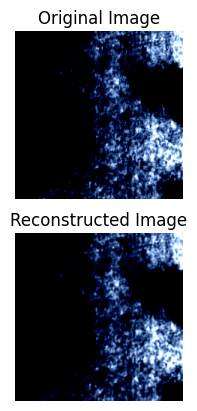

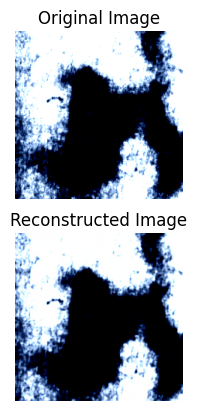

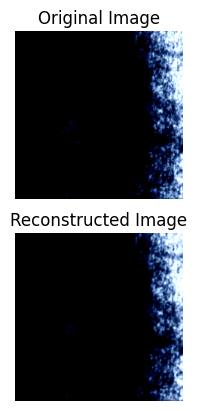

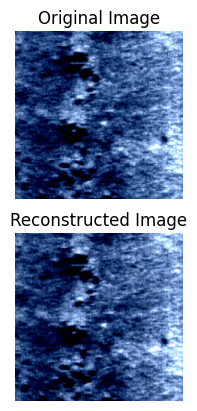

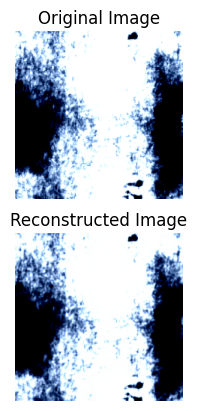

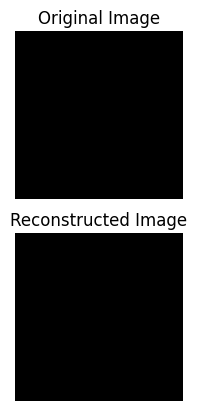

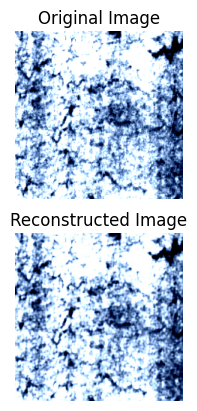

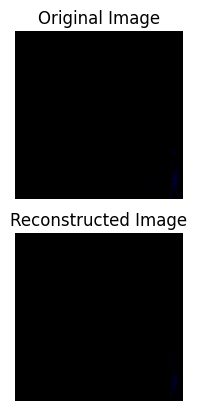

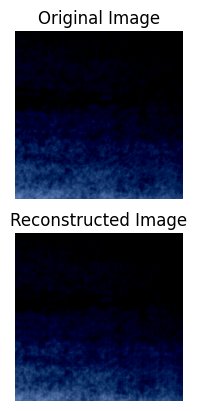

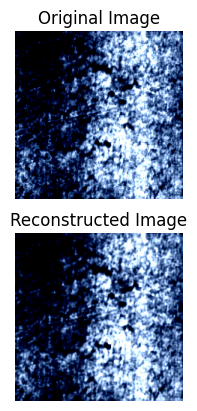

In [16]:
# Reconstruction of 50 random test images
import matplotlib.pyplot as plt

with torch.no_grad():
    for i in range(50):
        input_img, _ = next(iter(testloader))
        reconstructed_img = autoencoder(input_img)
        # Display the original and reconstructed images
        plt.subplot(2, 1, 1)
        plt.imshow(input_img.squeeze().permute(1, 2, 0))
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(2, 1, 2)
        plt.imshow(reconstructed_img.squeeze().permute(1, 2, 0))
        plt.title('Reconstructed Image')
        plt.axis('off')
        plt.show()